In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'  # force cpu
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# Load words
words = []
# with open("./data/western_names.txt") as file:
#     words = file.read().splitlines()

with open("./data/indian_names.csv", encoding="utf-8") as file:
    df = pd.read_csv(file, header=None)
    words = df.iloc[:, 0].dropna().tolist()
    words = [w.lower() for w in words if w.isalpha()]
    words = words[1:]
words[0:10]
min(len(w) for w in words), max(len(w) for w in words)
len("".join(w for w in words)) + len(
    words
)  # total chars from all words +len(words) for the dots

Using device: cpu
GPU: NVIDIA GeForce MX450
CUDA version: 12.6


45594

In [142]:
# Initialize character embeddings
unique_tokens = sorted(list(set("".join(words))))

token_to_idx = {ch: i + 1 for i, ch in enumerate(unique_tokens)}
token_to_idx["."] = 0
idx_to_token = {i: ch for ch, i in token_to_idx.items()}
vocab_size = len(token_to_idx)
eps = 1e-5

# hyperparameters on cpu
context_size = 4
embed_size = 8
batch_size = 32
network_size = 128

# hyperparameters on gpu
# context_size = 8
# embed_size = 64
# batch_size = 2048
# network_size = 1024


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * context_size
        for ch in w + ".":
            idx = token_to_idx[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [143]:
# Initialize parameters
g = torch.Generator(device=device).manual_seed(2147483647)

E = torch.randn((vocab_size, embed_size), generator=g, device=device)
W1 = torch.randn((context_size * embed_size, network_size), generator=g, device=device) * ((5/3) / (context_size * embed_size) ** 0.5)
b1 = torch.randn(network_size, generator=g, device=device) * 0.01
W2 = torch.randn((network_size, vocab_size), generator=g, device=device) * 0.01
b2 = torch.randn(vocab_size, generator=g, device=device) * 0

# batchnorm parameters
bn_gamma = torch.ones((1, network_size), device=device)
bn_beta = torch.zeros((1, network_size), device=device)
bn_mean_running = torch.zeros((1, network_size), device=device)
bn_std_running = torch.ones((1, network_size), device=device)

parameters = [E, W1, b1, W2, b2, bn_gamma, bn_beta]
for p in parameters:
    p.requires_grad = True

In [144]:
# training
X = X_train
Y = Y_train
lossi = []

for i in range(10_000):
    # mini-batch
    ix = torch.randint(0, X.size(0), (batch_size,), device=device)
    X_batch, Y_batch = X[ix], Y[ix]


    # forward pass
    # Input layer
    I = E[X_batch].view(-1, context_size * embed_size)

    # Linear layer
    H_preact = I @ W1 + b1

    # Batch normalization layer
    bn_mean_i = H_preact.mean(0, keepdim=True)
    bn_std_i = H_preact.std(0, keepdim=True)
    H_preact = bn_gamma * (H_preact - bn_mean_i) / (bn_std_i + eps) + bn_beta
    with torch.no_grad():
        bn_mean_running = 0.9 * bn_mean_running + 0.1 * bn_mean_i
        bn_std_running = 0.9 * bn_std_running + 0.1 * bn_std_i

    # Non-linear layer
    H = torch.tanh(H_preact)

    # Logit layer
    L = H @ W2 + b2
    loss = F.cross_entropy(L, Y_batch)


    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # update parameters
    learning_rate = 0.05 if i < 50_000 else 0.01
    for p in parameters:
        p.data += learning_rate * -p.grad

    # track stats
    lossi.append(loss.log10().item())
    if (i + 1) % 1_000 == 0:
        print(f"{i+1}: {loss.item():.4f}")

print(loss.item())

1000: 2.2060
2000: 1.6678
3000: 1.7965
4000: 1.5705
5000: 1.7703
6000: 1.7565
7000: 1.6380
8000: 1.5909
9000: 1.8778
10000: 1.7407
1.74074125289917


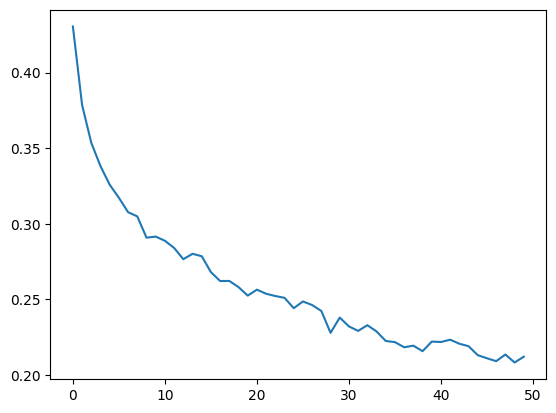

In [157]:
plt.plot(torch.tensor(lossi).view(-1,200).mean(dim=1))

In [145]:
@torch.no_grad()
def loss_by_split(split):
    X, Y = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]
    I = E[X].view(-1, context_size * embed_size)
    H_preact = I @ W1 + b1
    H_preact = (
        bn_gamma * (H_preact - bn_mean_running) / (bn_std_running + eps) + bn_beta
    )
    H = torch.tanh(H_preact)
    L = H @ W2 + b2
    loss = F.cross_entropy(L, Y)
    print(split, loss.item())
loss_by_split("val")
loss_by_split("test")

val 1.637766718864441
test 1.6443686485290527


In [148]:
# Generate samples
for _ in range(20):
    samples = []
    context = [0] * context_size
    while True:
        I = E[torch.tensor([context])].view(-1, context_size * embed_size)
        H = torch.tanh(I @ W1 + b1)
        logits = H @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        samples.append(idx)
        context = context[1:] + [idx]
        if idx == 0:
            break
    print("Generated samples:", "".join(idx_to_token[i] for i in samples))

Generated samples: nkhemyndengg.
Generated samples: subdkemcharashitambilchant.
Generated samples: shiv.
Generated samples: subdhhrem.
Generated samples: lumej.
Generated samples: godneky.
Generated samples: shwin.
Generated samples: himog.
Generated samples: shshryichyebhodephshuqsobyevhrumpulnlramshfun.
Generated samples: dhalcevurjymrnyink.
Generated samples: surman.
Generated samples: vrip.
Generated samples: bhimhalmesh.
Generated samples: rahul.
Generated samples: kamshannim.
Generated samples: ravimaykharvyy.
Generated samples: shind.
Generated samples: shidrum.
Generated samples: subhimahhajeep.
Generated samples: joggrajuydim.
